In [1]:
import networkx as nx
import math
import random
from matplotlib import pyplot
import imageio

In [2]:
def dijkstra(g: nx.Graph, source):
    for node in g.nodes:
        g.nodes[node]['distance'] = math.inf
        g.nodes[node]['predecessor'] = None
    
    q = set(g.nodes)
    g.nodes[source]['distance'] = 0
    
    while q:
        u = min(q, key=lambda x: g.nodes[x]['distance'])
        q.remove(u)
        
        for v in g.neighbors(u):
            try:
                alt = g.nodes[u]['distance'] + g.edges[u, v]['weight']
            except:
                alt = g.nodes[u]['distance']
            if alt < g.nodes[v]['distance']:
                g.nodes[v]['distance'] = alt
                g.nodes[v]['predecessor'] = u
    
    return [(node, g.nodes[node]['predecessor']) for node in g.nodes.keys() if g.nodes[node]['predecessor'] is not None]


In [3]:
def randomized_graph(num_nodes, edge_density, weight_range) -> nx.Graph:
    graph = nx.Graph()
    graph.add_nodes_from(range(num_nodes), distance=math.inf, predecessor=None)
    
    nodes = list(graph.nodes)
    num_edges = round((num_nodes + 1) * num_nodes / 2 * edge_density)
    i = 0
    while i < num_edges:
        u, v = random.choices(nodes, k=2)
        if not graph.has_edge(u, v):
            graph.add_edge(u, v, weight=random.randint(*weight_range))
            i += 1
    return graph


In [4]:
def graph_from_file():

    graph = nx.Graph()

    node_count = None
    start_node = None
    end_node = None
    weight_table = {}

    with open('input.txt') as f:
        # read node info
        for _ in range(3):
            key, value = f.readline().split('=', maxsplit=1)
            if key == 'n':
                node_count = int(value)
            elif key == 's':
                start_node = int(value)
            elif key == 't':
                end_node = int(value)

        graph.add_nodes_from(range(1, node_count + 1))

        f.readline()

        for u in range(1, node_count + 1):
            for v, weight in enumerate(f.readline().split(', '), start=1):
                if u == v:
                    continue
                graph.add_edge(u, v, weight=int(weight))

    return graph

In [5]:
def plot(graph, pos, *, 
         highlight_edges=None, 
         highlight_nodes=None, 
         highlight_edge_labels=None, 
         highlight_node_labels=None, 
         labels=None,
         exclude_nodes=None,
         exclude_edges=None):
    figure = pyplot.figure(dpi=300, figsize=(10, 10))
    
    nodes = graph.nodes - (set(exclude_nodes) if exclude_nodes is not None else {})
    edges = graph.edges - (set(exclude_edges) if exclude_edges is not None else {})
    
    nx.draw(graph, pos, node_color='orange', nodelist=nodes, edgelist=edges)
    
    if labels is None:
        labels = len(graph.nodes) <= 25
    
    if labels:
        node_labels = {node: (node, g.nodes[node]['distance'], g.nodes[node]['predecessor']) for node in g.nodes}
        nx.draw_networkx_labels(g, pos, labels=node_labels)

        edge_labels = {edge: g.edges[edge]['weight'] for edge in g.edges}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)

    if highlight_nodes is not None:
        if not isinstance(highlight_nodes, list):
            highlight_nodes = [highlight_nodes]
        for nodes, params in highlight_nodes:
            if not isinstance(nodes, list):
                nodes = [nodes]
            nx.draw_networkx_nodes(g, pos, nodelist=nodes, **params)
            
    if highlight_node_labels is not None:
        if not isinstance(highlight_node_labels, list):
            highlight_node_labels = [highlight_node_labels]
        for nodes, params in highlight_node_labels:
            if not isinstance(nodes, list):
                nodes = [nodes]
            nx.draw_networkx_node_labels(g, pos, labels=nodes, **params)
            
    if highlight_edges is not None:
        if not isinstance(highlight_edges, list):
            highlight_edges = [highlight_edges]
        for edges, params in highlight_edges:
            nx.draw_networkx_edges(g, pos, edgelist=edges, **params)
            
    if highlight_edge_labels is not None:
        if not isinstance(highlight_edge_labels, list):
            highlight_edge_labels = [highlight_edge_labels]
        for edges, params in highlight_edge_labels:
            nx.draw_networkx_edge_labels(g, pos, edge_labels=edges, **params)
    
    return figure

In [6]:
def find_path(graph, tree, start, end):
    """
    follows the tree to try to get from start to end, and returns the path they used.
    """
    stack = [(start, [start])]
    while stack:
        v, path = stack.pop()
        for u in set(graph.neighbors(v)) - set(path):
            if (u, v) in tree or (v, u) in tree:
                if u == end:
                    path.append(u)
                    return [(i,j) for i,j in zip(path[:-1], path[1:])]
                else:
                    stack.append((u, path + [u]))

    
    
    

In [7]:
def random_weight_change(graph, edge, weight_range=(1, 100)):
    old_weight = graph.edges[edge]['weight']
    new_weight = random.randint(*weight_range)
    graph.edges[edge]['weight'] = new_weight
    return edge, old_weight, new_weight

In [8]:
def random_inc_in_path(graph, path, weight_range=(1, 100)):
    edge = random.choice(path)
    lower_bound = graph.edges[edge]['weight']
    return random_weight_change(graph, edge, (lower_bound, weight_range[1]))

In [9]:
def random_decr_out_path(graph, path, weight_range=(1, 100)):
    edge = random.choice(list(set(graph.edges) - set(path)))
    upper_bound = graph.edges[edge]['weight']
    return random_weight_change(graph, edge, (weight_range[0], upper_bound))

In [10]:
def random_decr_adjacent_path(graph, path, weight_range=(1, 100)):
    edge = random.choice(path)
    u = random.choice(edge)
    for v in graph.neighbors(u):
        if (u,v) in path or (v,u) in path:
            continue
        adjacent_edge = (u, v)
        return random_weight_change(graph, adjacent_edge, weight_range)
    

In [11]:
# g: nx.Graph = randomized_graph(10, 0.5, (1, 100))
g: nx.Graph = graph_from_file()
pos = nx.spring_layout(g)
# g: nx.Graph = nx.random_geometric_graph(30, .25)
# for node in g.nodes:
#     g.nodes[node]['distance'] = math.inf
#     g.nodes[node]['predecessor'] = None
# for edge in g.edges:
#     g.edges[edge]['weight'] = random.randint(1, 100)
# pos = {node: g.nodes[node]['pos'] for node in g.nodes}
# pos = nx.draw_spring(g)

In [12]:
start = random.choice(list(g.nodes))
end = random.choice(list(g.nodes))
while start == end:
    end = random.choice(list(g.nodes))

In [13]:
# dijkstra_tree = dijkstra(g, start)
# plot(g, pos, 
#      highlight_nodes=[
#          (start, dict(node_color='green', node_size=600)), 
#          (end, dict(node_color='red', node_size=600))
#      ],
#      highlight_edges=(dijkstra_tree, dict(edge_color='red')))

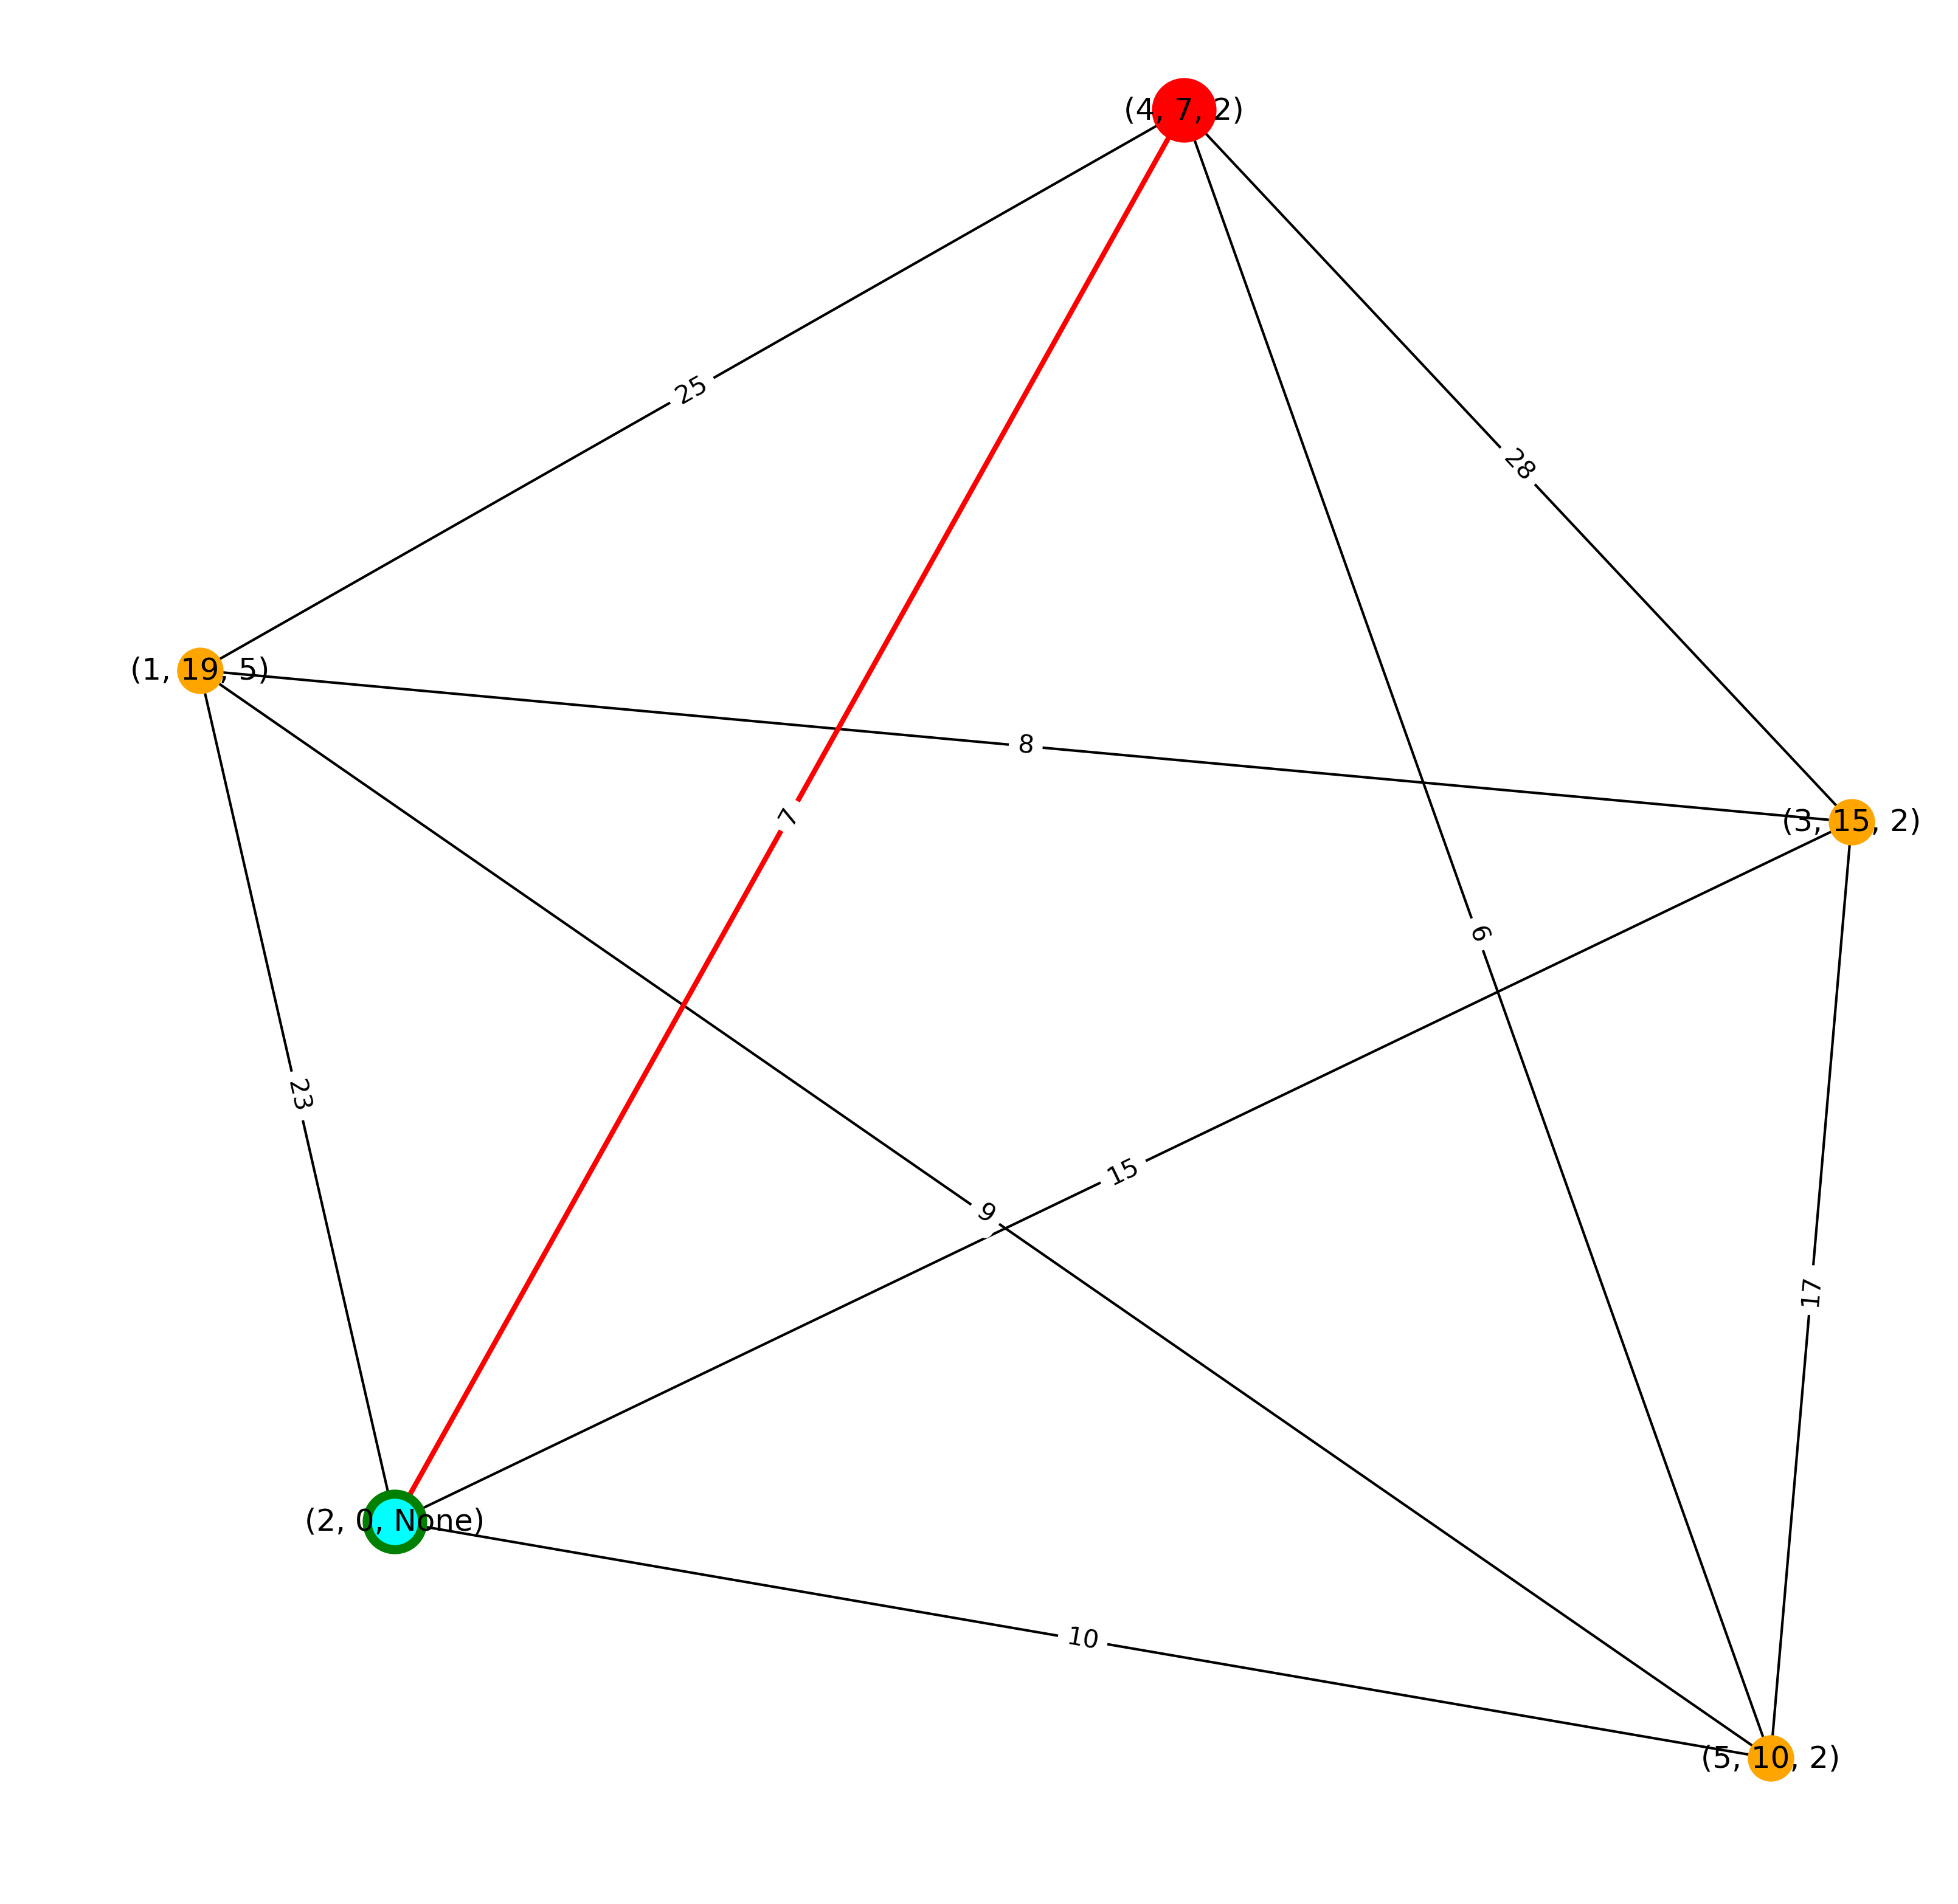

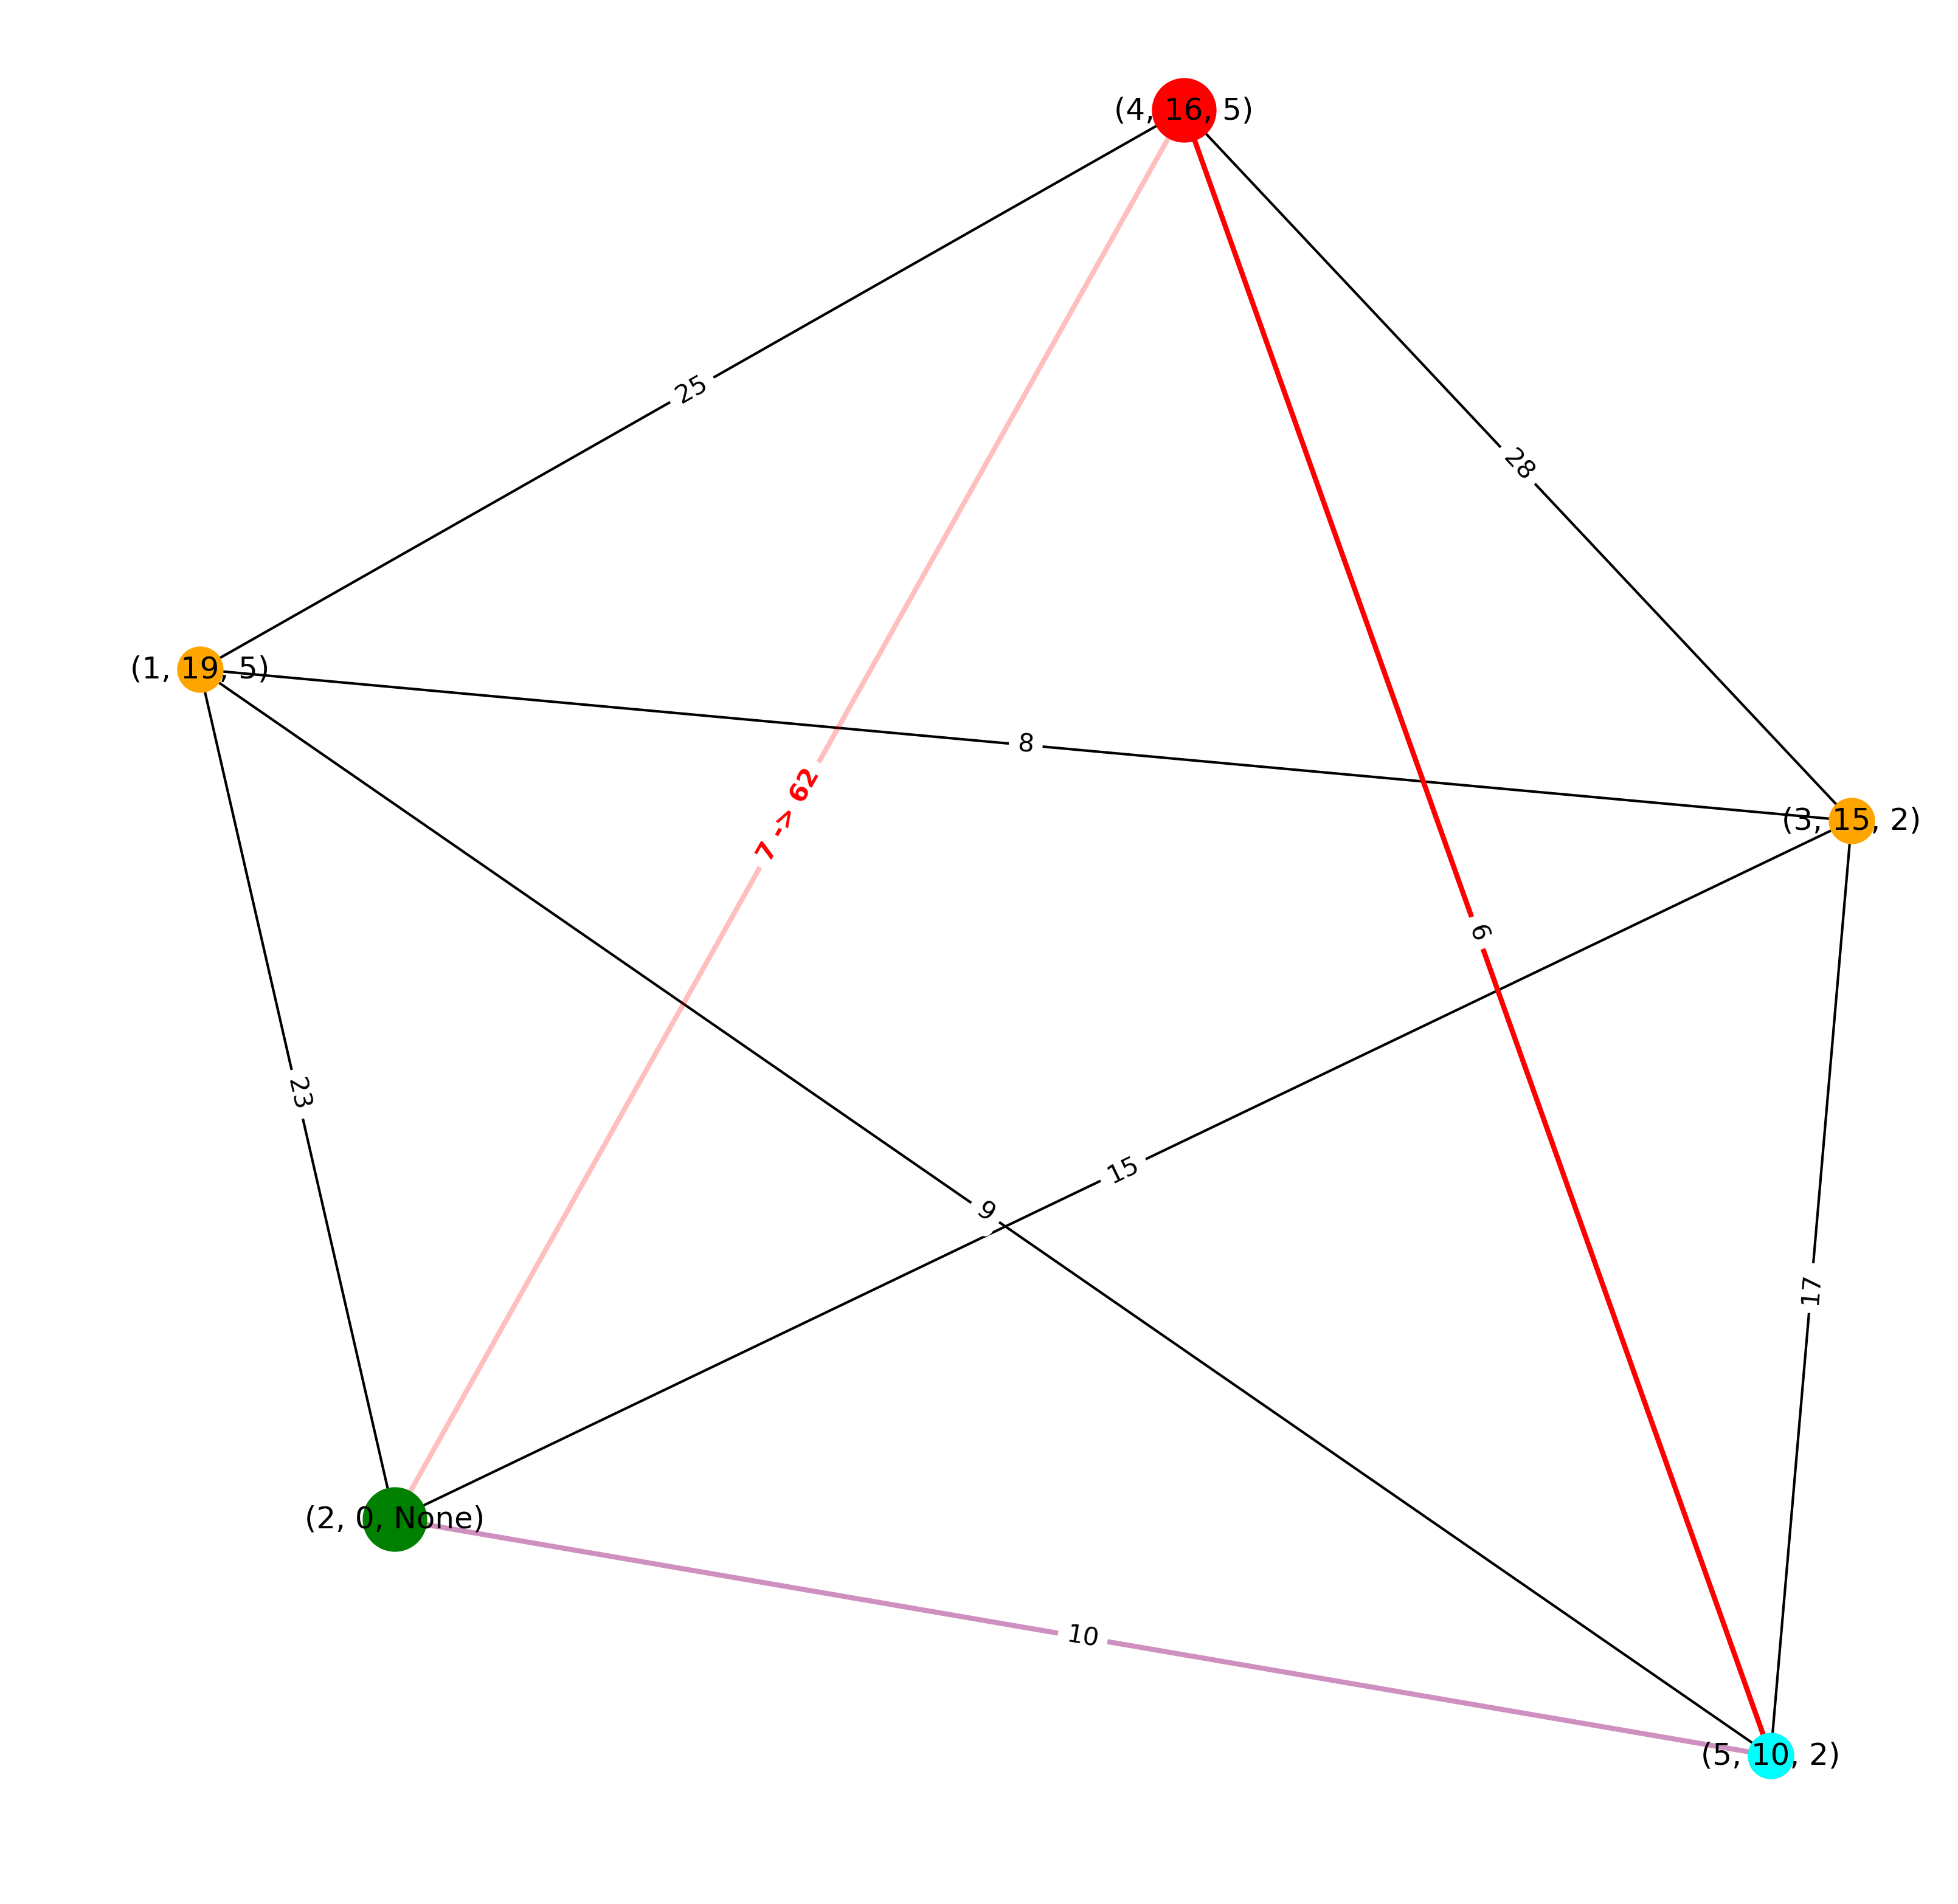

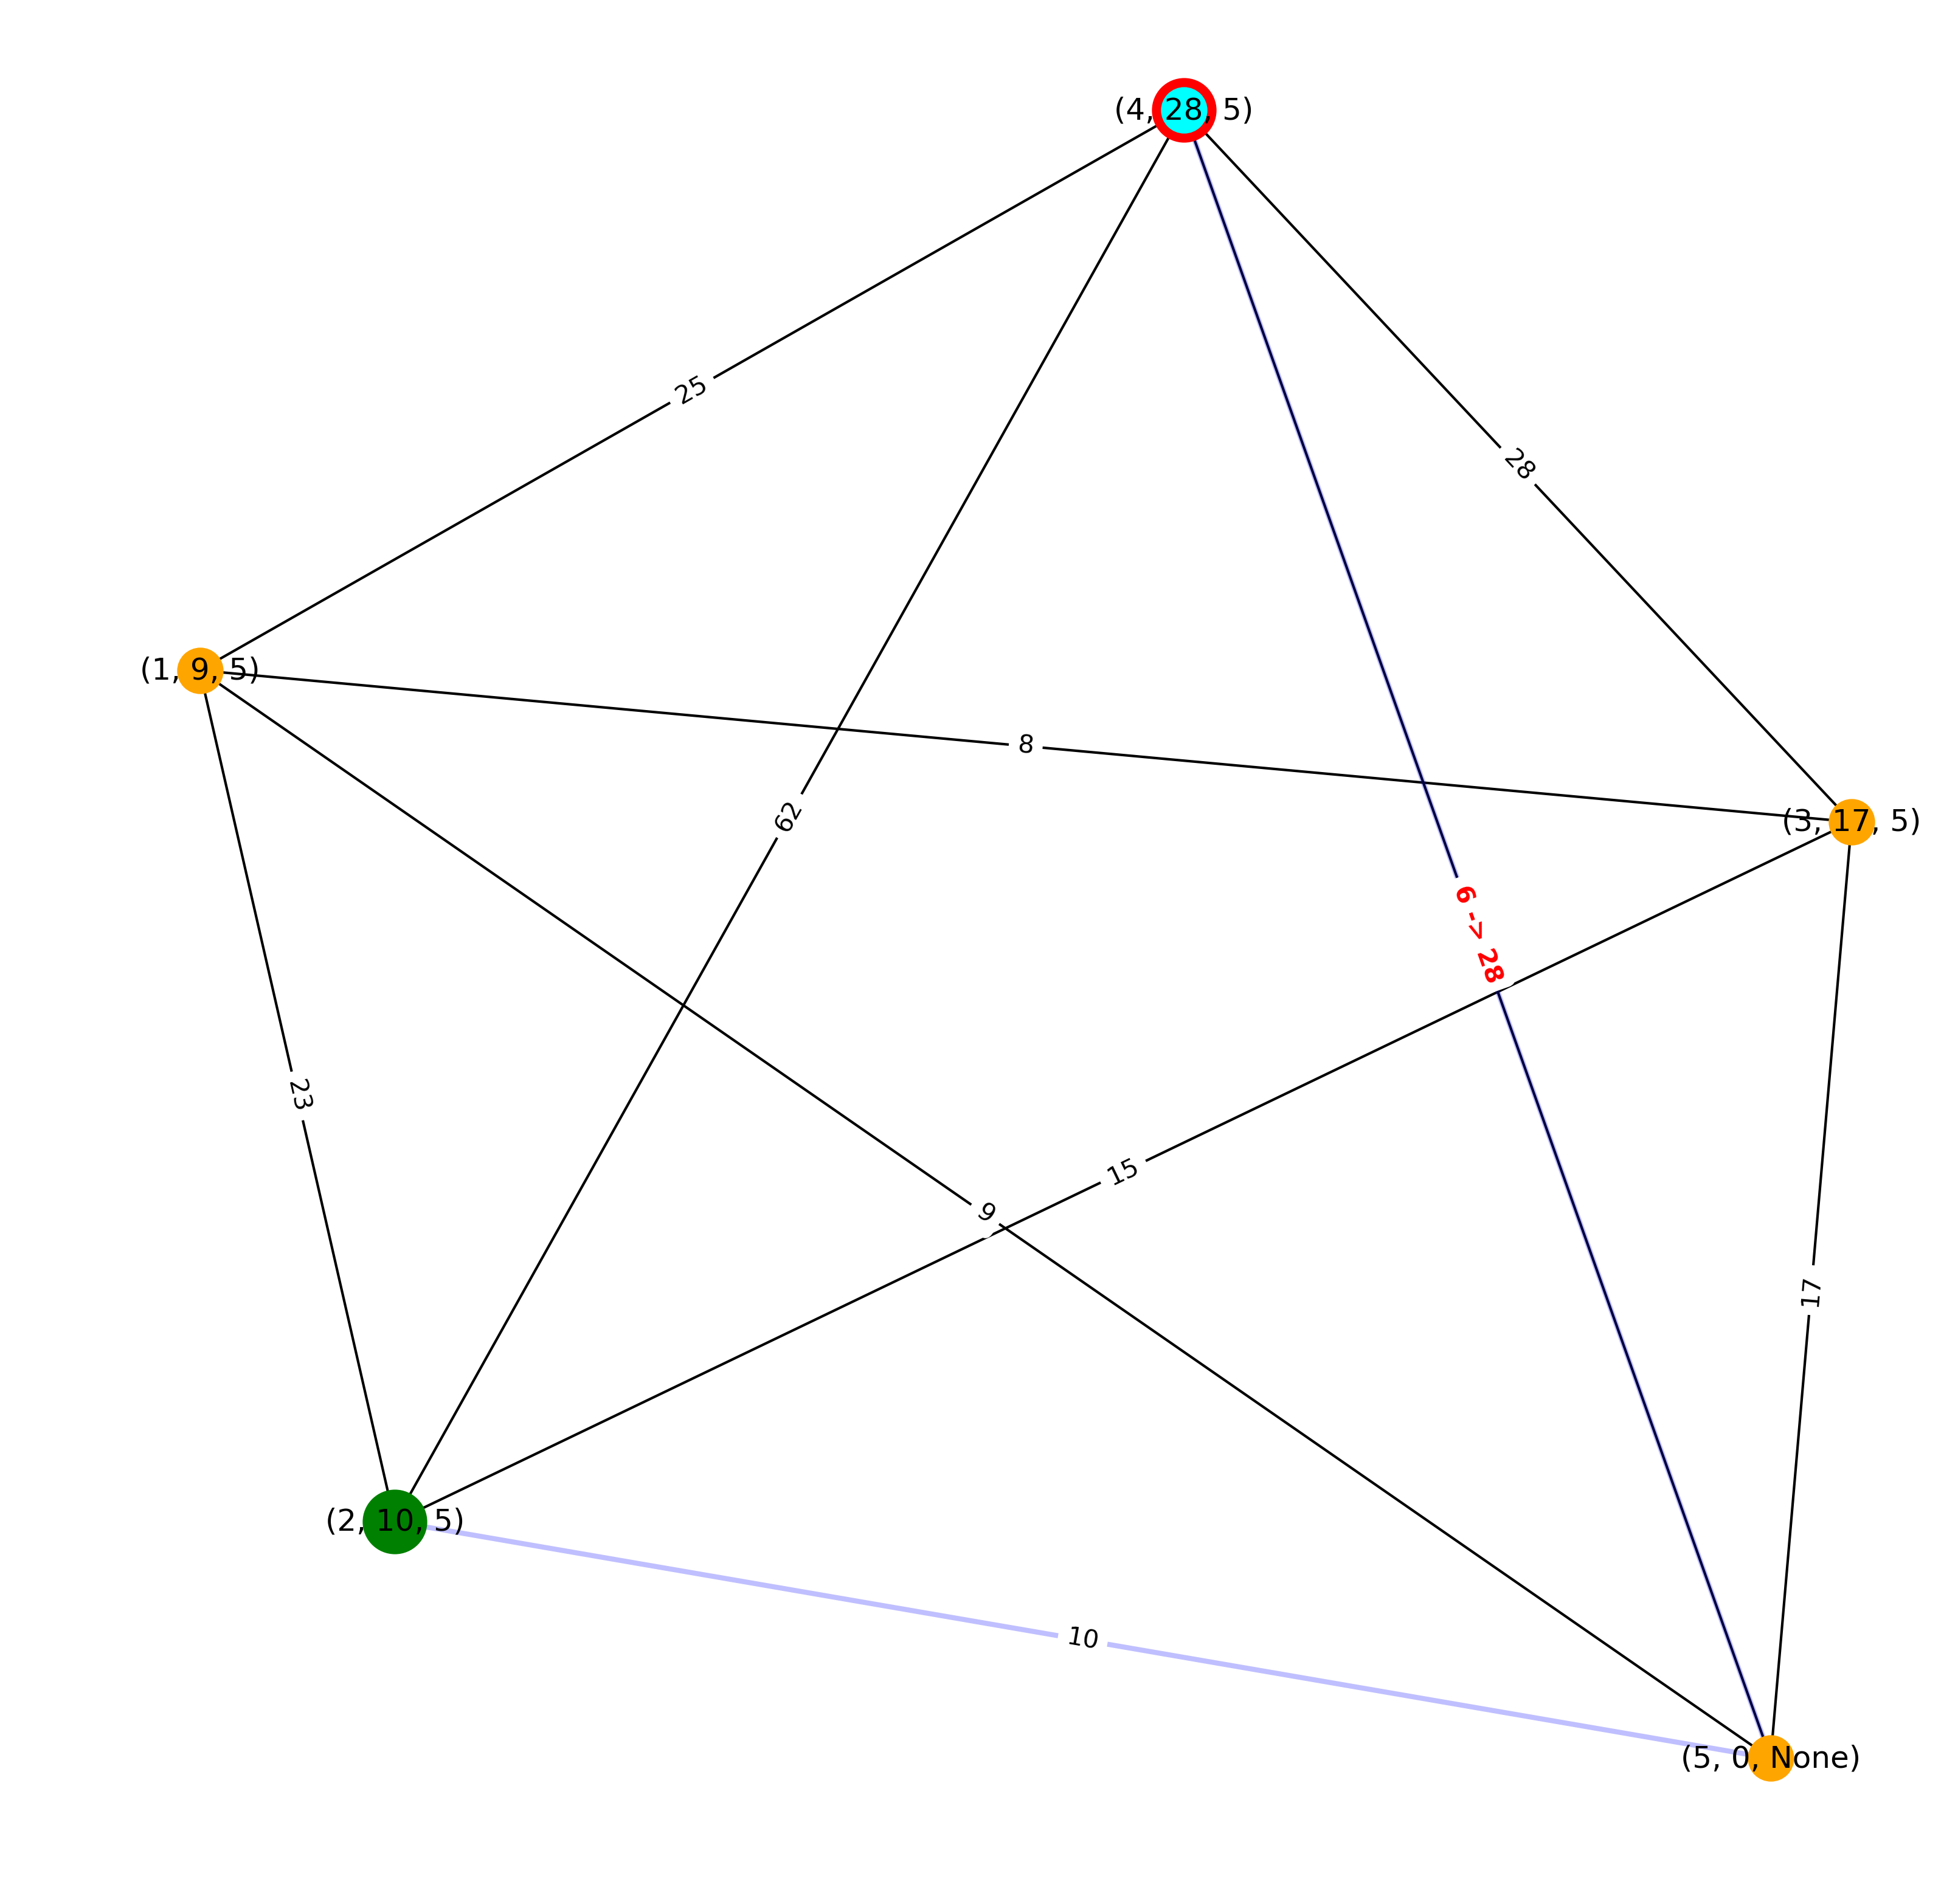

In [14]:
current = start
dijkstra_tree = dijkstra(g, start)
path = find_path(g, dijkstra_tree, start, end) or []
fig = plot(g, pos, 
     highlight_edges=(path, dict(edge_color='red', width=2)),
     highlight_nodes=[
         (start, dict(node_color='green', node_size=600)), 
         (end, dict(node_color='red', node_size=600)),
         (current, dict(node_color='cyan'))
     ]
  )
fig.savefig('0.png')
history = set()
delta = set()
i = 0
while current != end and path:
    changed_edge, old_weight, new_weight = random_inc_in_path(g, path, (1, 100))
    dijkstra_tree = dijkstra(g, current)
    old_path = path
    path = find_path(g, dijkstra_tree, current, end) or []
    delta = set(path) ^ set(old_path)
    edge = path.pop(0)
    history.add(edge)
    current = edge[1]
    fig = plot(g, pos, 
         highlight_edges=[
             (path, dict(edge_color='red', width=2)),
             (history, dict(edge_color='blue', alpha=0.25, width=2)),
             (delta, dict(edge_color='red', alpha=0.25, width=2))
         ],
         highlight_edge_labels=(
             {changed_edge: f'{old_weight} -> {new_weight}'}, 
             dict(font_color='red', font_weight='bold')
         ),
         highlight_nodes=[
             (start, dict(node_color='green', node_size=600)), 
             (end, dict(node_color='red', node_size=600)),
             (current, dict(node_color='cyan')),
         ],
         exclude_edges=delta | history
        )
    i+=1
    fig.savefig(f'{i}.png')

In [15]:
images = [imageio.imread(f'{j}.png') for j in range(i+1)]
imageio.mimsave('animation.gif', images, duration=1)

In [16]:
# from pathlib import Path
# for j in range(i):
#     file = Path(f'{j}.png')
#     file.unlink()

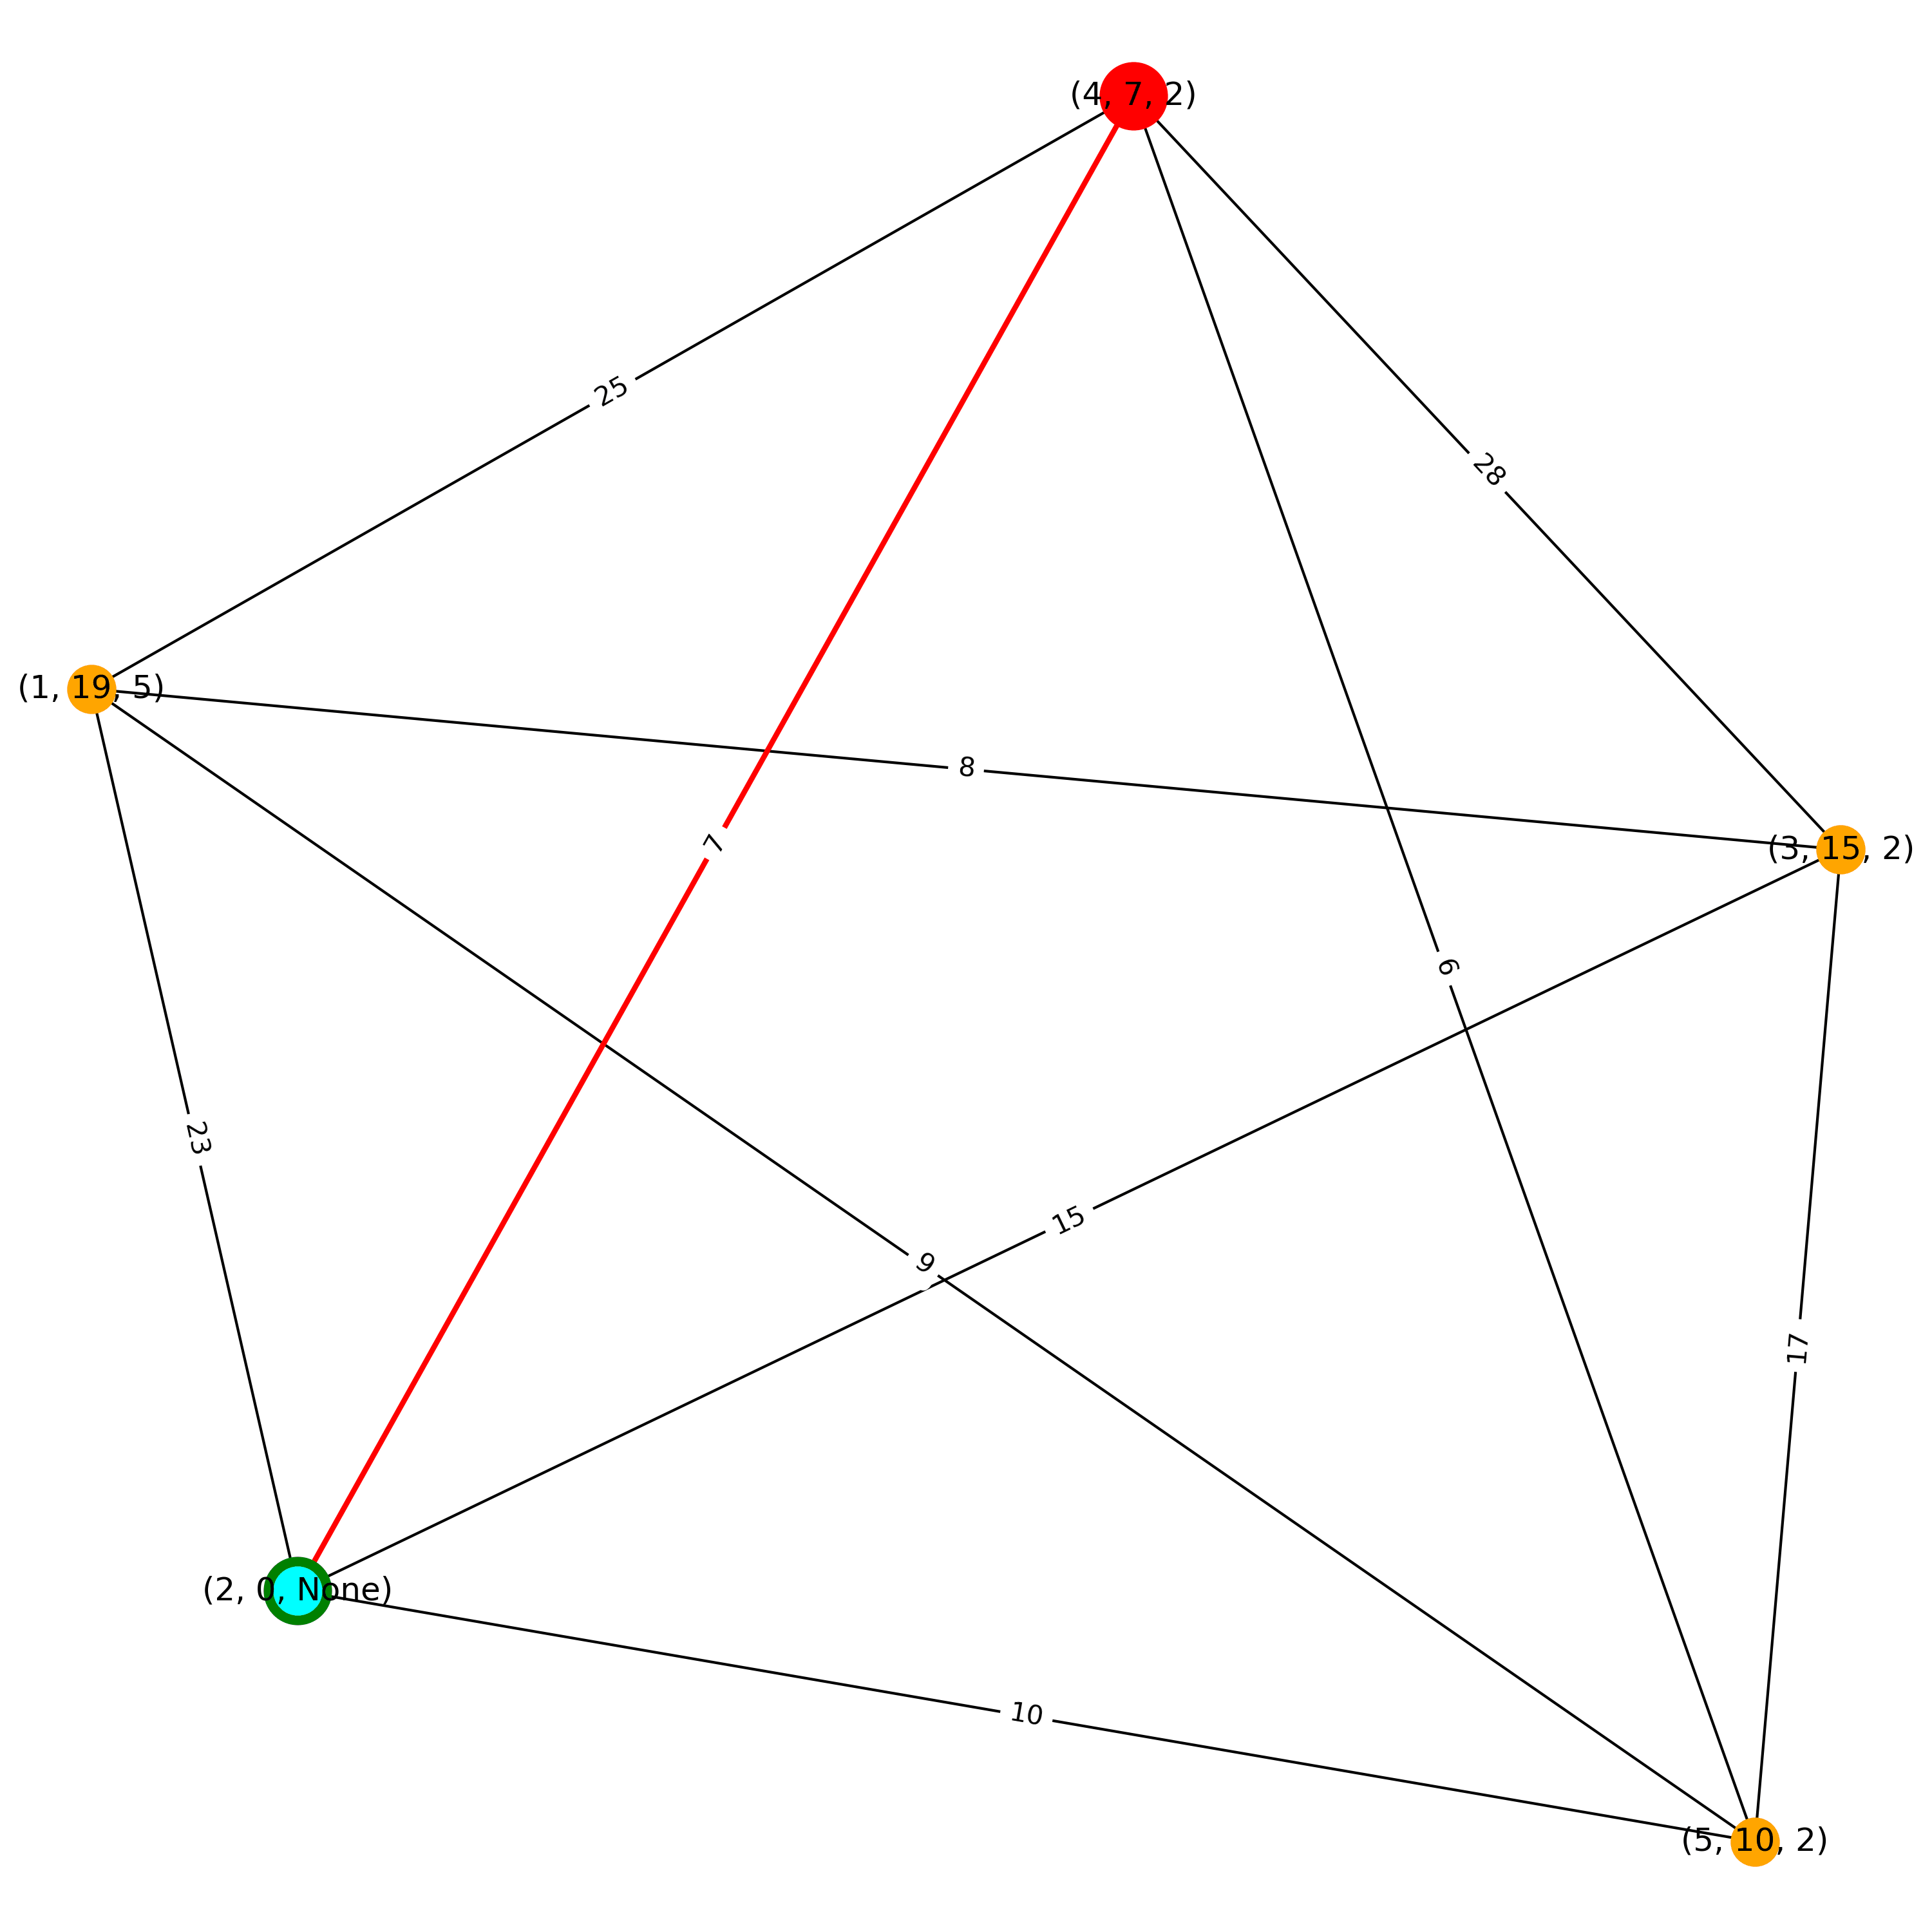

In [17]:
from IPython.display import Image
img = Image(filename='animation.gif', format='png', embed=True)
img.reload()
img

<img href="animation.gif" />